# Setup

In [37]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
import torch
from torch.nn.functional import softmax
import datasets
from datasets import load_dataset, Dataset
import random
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import F1Score
import pandas as pd

# Run

## 3-class

### Try the model

In [2]:
tokenizer = RobertaTokenizer.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")
model = RobertaForSequenceClassification.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")

# Print the total number of parameters in millions (M)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params / 1e6:.1f}M")

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/355 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/894 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

Total number of parameters: 82.1M


In [3]:
def test_1(input_text):
  # Tokenize input and get model output
  inputs = tokenizer(input_text, return_tensors="pt")

  # Get logits (output for classification)
  outputs = model(**inputs)
  logits = outputs.logits

  # Convert logits to probabilities using softmax
  probs = softmax(logits, dim=1)

  # Map classes to polarity values
  polarity_values = torch.tensor([-1.0, 0.0, 1.0])

  # Calculate polarity score as the weighted sum of probabilities
  polarity_score = torch.sum(probs * polarity_values, dim=1).item()

  # Get the predicted class (optional, for reference)
  predicted_class = logits.argmax(dim=1).item()

  print(f"Predicted class: {predicted_class}")
  print(f"Polarity score: {polarity_score:.2f}")

# Positive class
input_text = "The Bitcoin market will continue to grow"
test_1(input_text)

# Neutral class
input_text = "The Bitcoin market will remain steady"
test_1(input_text)

# Negative class
input_text = "The Bitcoin market is trending down"
test_1(input_text)

Predicted class: 2
Polarity score: 0.86
Predicted class: 1
Polarity score: 0.49
Predicted class: 0
Polarity score: -0.99


### Fine tune the model

In [3]:
# del model

In [2]:
# Set a fixed random seed for reproducibility
random.seed(42)

# Load the dataset from Hugging Face
dataset = load_dataset("kisejin/finance_sentiment_dataset")

# Convert string labels to integers
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}

# Split data by sentiment label
negative_samples = [sample for sample in dataset["train"] if sample["output"] == "negative"]
positive_samples = [sample for sample in dataset["train"] if sample["output"] == "positive"]
neutral_samples = [sample for sample in dataset["train"] if sample["output"] == "neutral"]

# Get the number of negative samples to balance
num_samples = 3000 # len(negative_samples)

# Randomly select same number of positive and neutral samples
balanced_negative_samples = random.sample(negative_samples, num_samples)
balanced_positive_samples = random.sample(positive_samples, num_samples)
balanced_neutral_samples = random.sample(neutral_samples, num_samples)

# Combine all into a new dataset
balanced_dataset = balanced_negative_samples + balanced_positive_samples + balanced_neutral_samples

# Convert 'output' field to integers
for sample in balanced_dataset:
    sample['output'] = label_mapping[sample['output']]

# Optional: Convert it to a Hugging Face dataset for compatibility
from datasets import Dataset
balanced_dataset = Dataset.from_dict({k: [d[k] for d in balanced_dataset] for k in balanced_dataset[0].keys()})

#### Trial #1

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 900/2700 [35:00<1:12:25,  2.41s/it]

Epoch 1/3: train loss 0.4245, val loss 0.3071, val accuracy 0.8878


 67%|██████▋   | 1800/2700 [1:18:18<36:50,  2.46s/it]  

Epoch 2/3: train loss 0.2174, val loss 0.2600, val accuracy 0.9100


100%|██████████| 2700/2700 [1:55:45<00:00,  2.31s/it]   

Epoch 3/3: train loss 0.1365, val loss 0.2824, val accuracy 0.9144


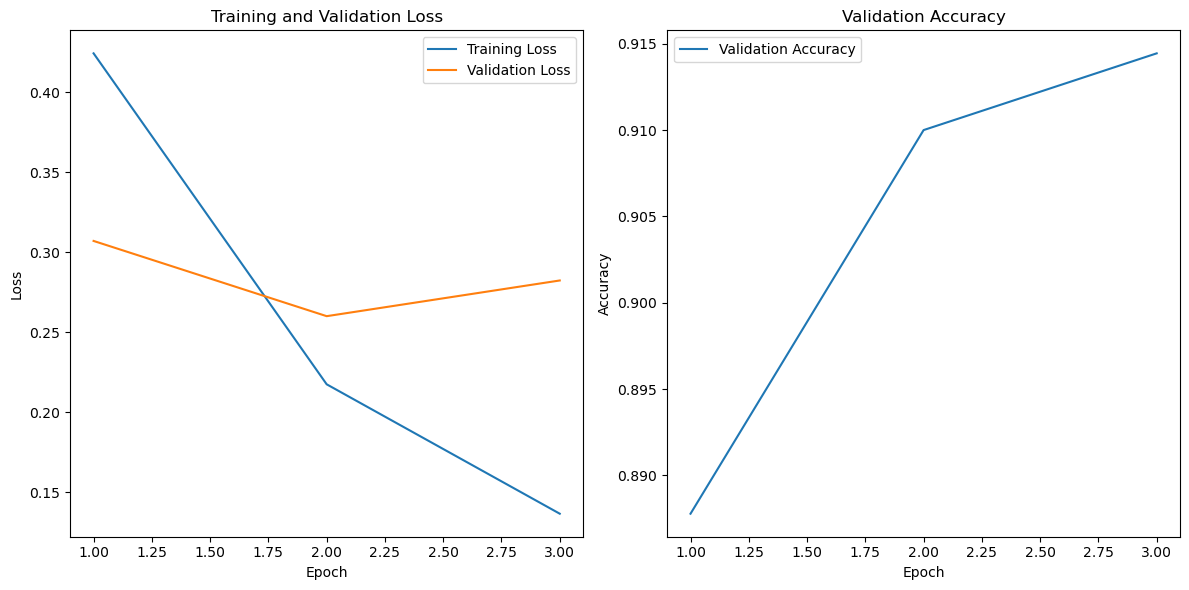

Final validation accuracy: 0.9144


In [5]:
# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")
model = RobertaForSequenceClassification.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        correct_predictions += (predictions == batch["labels"]).sum().item()
        total_predictions += batch["labels"].size(0)

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val accuracy {val_accuracies[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_accuracies)

# Print final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")

#### Trial #2

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 20%|██        | 900/4500 [35:22<2:15:47,  2.26s/it]

Epoch 1/5: train loss 0.4597, val loss 0.3637, val accuracy 0.8600


 40%|████      | 1800/4500 [1:13:03<1:47:46,  2.40s/it]

Epoch 2/5: train loss 0.2802, val loss 0.3132, val accuracy 0.8961


 60%|██████    | 2700/4500 [1:50:29<1:08:42,  2.29s/it] 

Epoch 3/5: train loss 0.2113, val loss 0.2863, val accuracy 0.9006


 80%|████████  | 3600/4500 [2:28:05<36:01,  2.40s/it]   

Epoch 4/5: train loss 0.1475, val loss 0.2935, val accuracy 0.9078


100%|██████████| 4500/4500 [3:05:54<00:00,  2.38s/it]  

Epoch 5/5: train loss 0.1314, val loss 0.3014, val accuracy 0.9089


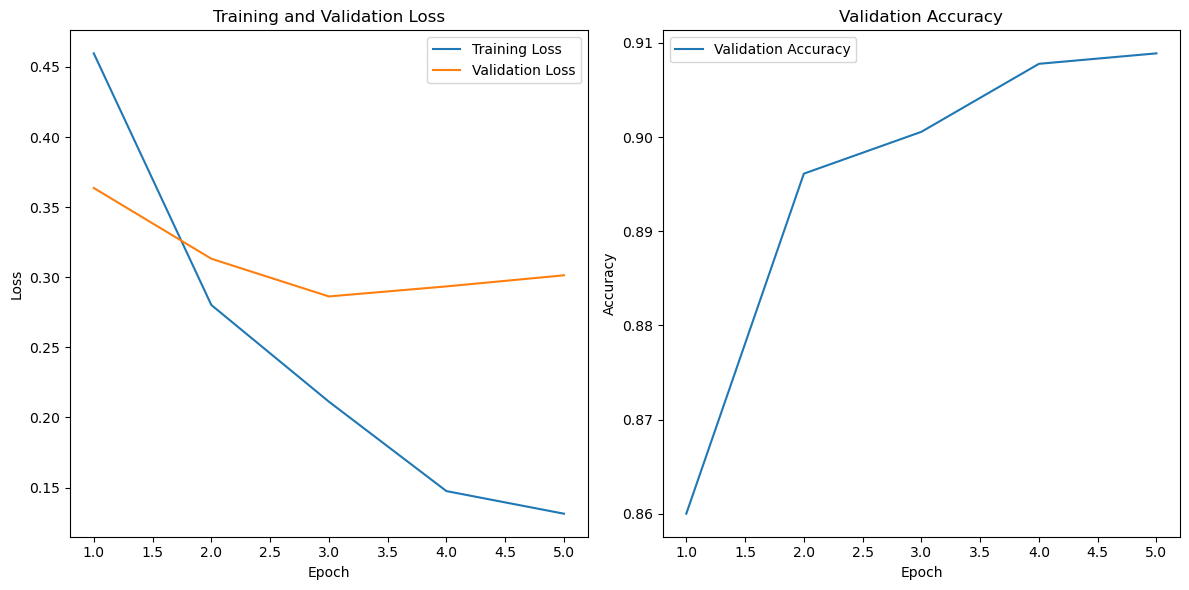

Final validation accuracy: 0.9089


In [3]:
# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")
model = RobertaForSequenceClassification.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-6)
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        correct_predictions += (predictions == batch["labels"]).sum().item()
        total_predictions += batch["labels"].size(0)

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val accuracy {val_accuracies[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_accuracies)

# Print final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")

#### Trial #3

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 20%|██        | 900/4500 [34:35<2:17:29,  2.29s/it]

Epoch 1/5: train loss 0.5963, val loss 0.4764, val accuracy 0.8122


 40%|████      | 1800/4500 [1:14:47<1:39:19,  2.21s/it]

Epoch 2/5: train loss 0.4498, val loss 0.4233, val accuracy 0.8339


 60%|██████    | 2700/4500 [1:51:50<1:07:42,  2.26s/it] 

Epoch 3/5: train loss 0.4050, val loss 0.3964, val accuracy 0.8517


 80%|████████  | 3600/4500 [2:29:50<38:18,  2.55s/it]   

Epoch 4/5: train loss 0.3741, val loss 0.3875, val accuracy 0.8556


100%|██████████| 4500/4500 [3:06:32<00:00,  2.48s/it]  

Epoch 5/5: train loss 0.3629, val loss 0.3843, val accuracy 0.8572


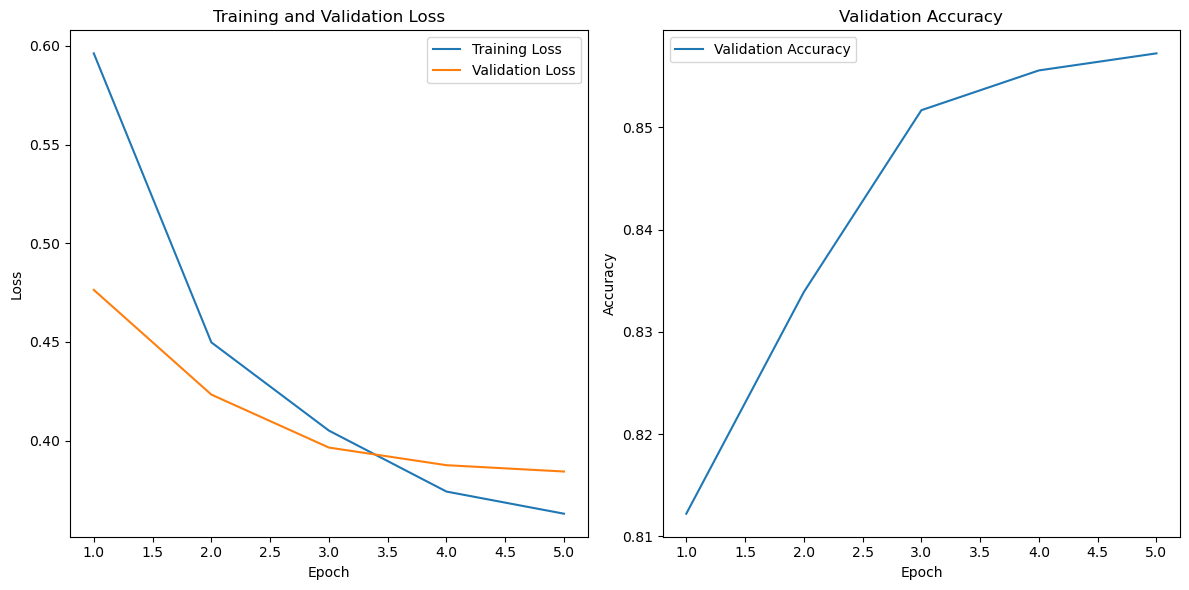

Final validation accuracy: 0.8572


In [5]:
# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")
model = RobertaForSequenceClassification.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=1e-6)
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        correct_predictions += (predictions == batch["labels"]).sum().item()
        total_predictions += batch["labels"].size(0)

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val accuracy {val_accuracies[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_accuracies)

# Print final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")

#### Trial #4

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 900/2700 [39:24<1:18:26,  2.61s/it]

Epoch 1/3: train loss 0.4735, val loss 0.3743, val accuracy 0.8589


 67%|██████▋   | 1800/2700 [1:17:12<33:30,  2.23s/it]

Epoch 2/3: train loss 0.2940, val loss 0.3101, val accuracy 0.8889


100%|██████████| 2700/2700 [1:54:27<00:00,  2.71s/it]  

Epoch 3/3: train loss 0.2231, val loss 0.3112, val accuracy 0.8928


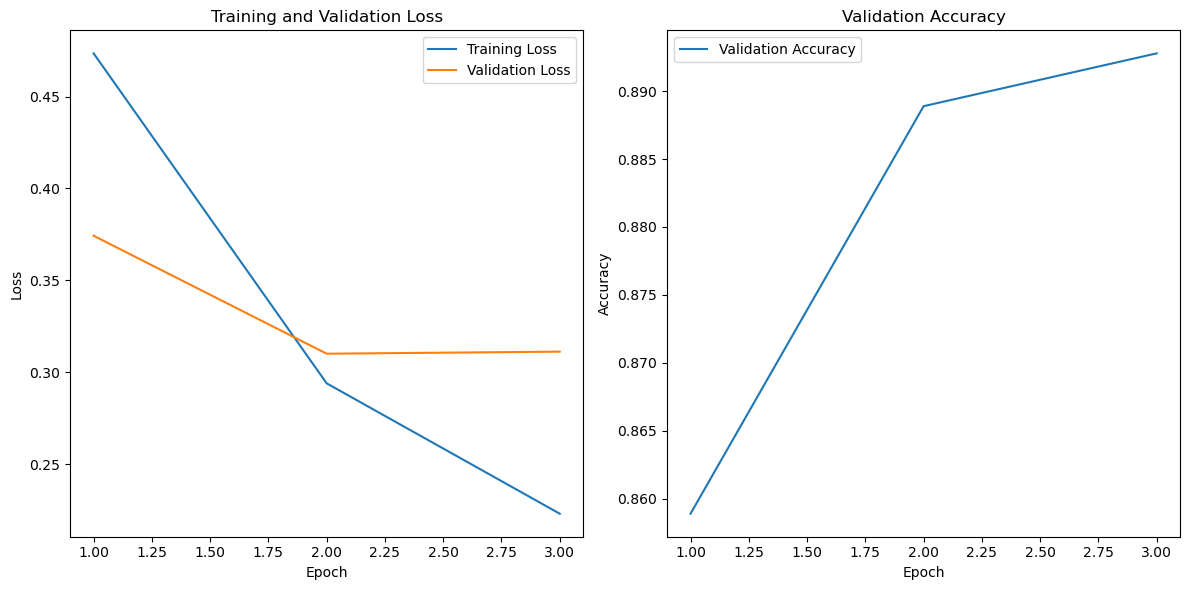

Final validation accuracy: 0.8928


In [3]:
# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")
model = RobertaForSequenceClassification.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-6)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        correct_predictions += (predictions == batch["labels"]).sum().item()
        total_predictions += batch["labels"].size(0)

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val accuracy {val_accuracies[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_accuracies)

# Print final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")

In [4]:
modelsavename = "distilroberta_9k_ep3_8928.pt"

# Save the model's state_dict
with open(modelsavename, "wb") as f:
    torch.save(model.state_dict(), f)

print(f"Model saved as {modelsavename}")

Model saved as distilroberta_9k_ep3_8928.pt


#### Trial #5

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 20%|██        | 900/4500 [38:17<2:29:42,  2.50s/it]

Epoch 1/5: train loss 0.4962, val loss 0.3917, val accuracy 0.8528


 40%|████      | 1800/4500 [1:16:43<1:47:33,  2.39s/it]

Epoch 2/5: train loss 0.3347, val loss 0.3361, val accuracy 0.8800


 60%|██████    | 2700/4500 [1:54:30<1:12:43,  2.42s/it] 

Epoch 3/5: train loss 0.2651, val loss 0.3222, val accuracy 0.8917


 80%|████████  | 3600/4500 [2:31:15<33:30,  2.23s/it]   

Epoch 4/5: train loss 0.2260, val loss 0.3038, val accuracy 0.8978


100%|██████████| 4500/4500 [3:06:39<00:00,  2.27s/it]  

Epoch 5/5: train loss 0.2009, val loss 0.3099, val accuracy 0.8972


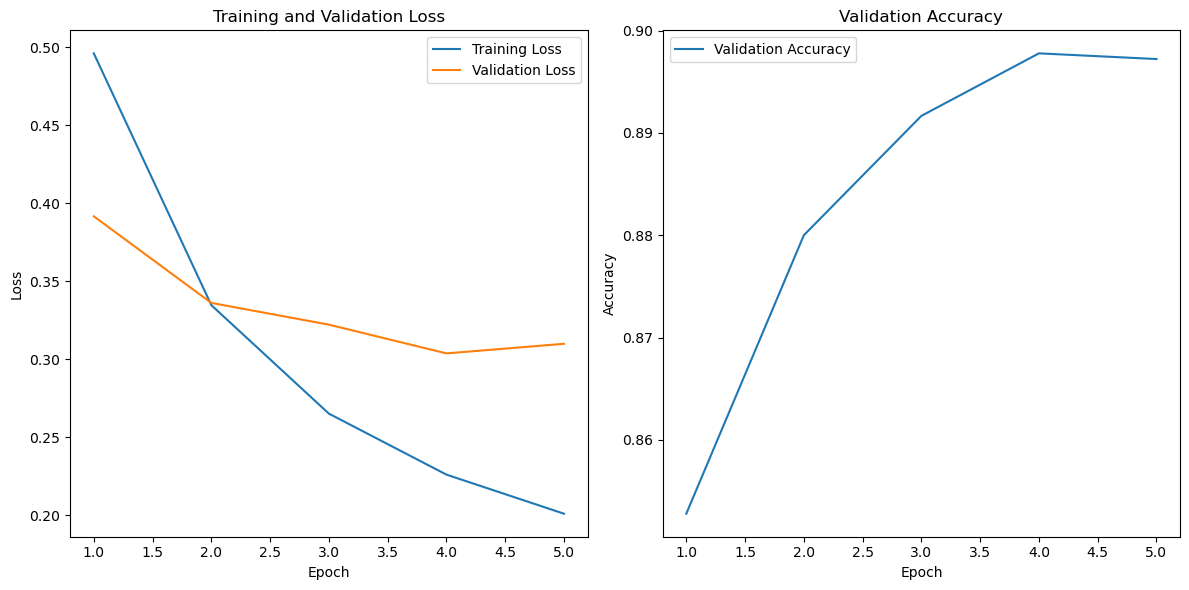

Final validation accuracy: 0.8972


In [5]:
# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")
model = RobertaForSequenceClassification.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=3e-6)
num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_accuracies = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        correct_predictions += (predictions == batch["labels"]).sum().item()
        total_predictions += batch["labels"].size(0)

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_accuracy = correct_predictions / total_predictions
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val accuracy {val_accuracies[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Validation Accuracy')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_accuracies)

# Print final validation accuracy
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")

#### Trial #6 (use F1)

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 900/2700 [42:08<2:15:24,  4.51s/it]

Epoch 1/3: train loss 0.4616, val loss 0.3582, val f1 score 0.8721


 67%|██████▋   | 1800/2700 [1:52:55<1:14:02,  4.94s/it]

Epoch 2/3: train loss 0.2886, val loss 0.3058, val f1 score 0.8932


100%|██████████| 2700/2700 [3:05:49<00:00,  4.09s/it]   

Epoch 3/3: train loss 0.2202, val loss 0.3006, val f1 score 0.8975


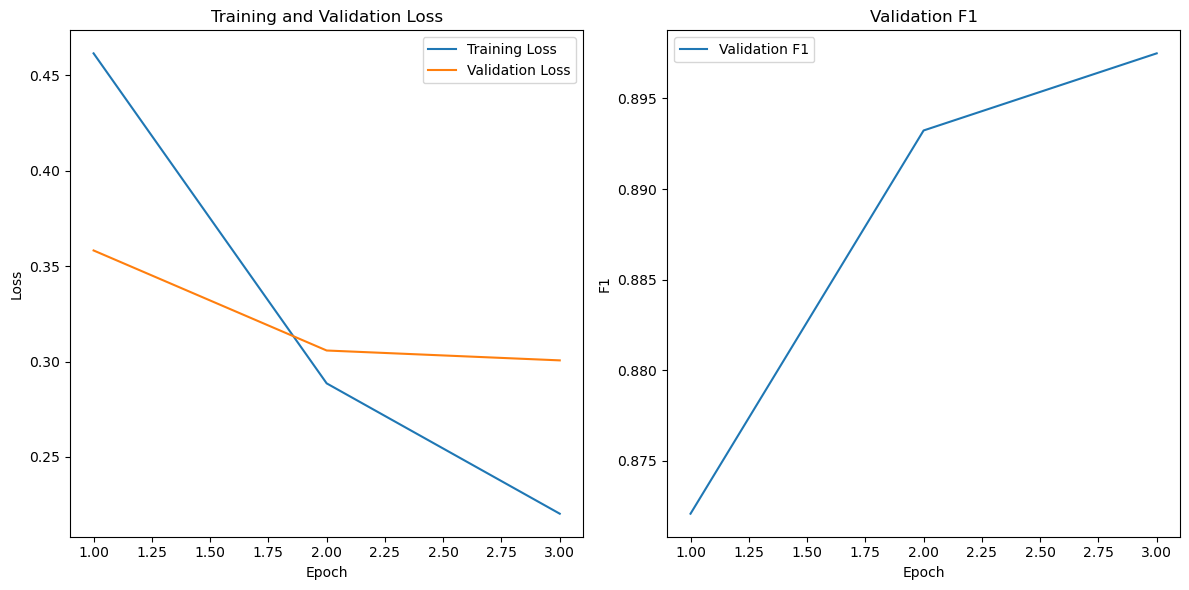

Final validation accuracy: 0.8975


In [3]:
# Load the tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")
model = RobertaForSequenceClassification.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["input"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets = balanced_dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["instruction", "input"])
tokenized_datasets = tokenized_datasets.rename_column("output", "labels")
tokenized_datasets.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset = tokenized_datasets.shuffle(seed=42)
train_size = int(0.8 * len(shuffled_train_dataset))  # 80% for training
small_train_dataset = shuffled_train_dataset.select(range(train_size))
small_eval_dataset = shuffled_train_dataset.select(range(train_size, len(shuffled_train_dataset)))

# Dataloaders
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-6)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# Move model to device (GPU if available)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Initialize lists to track training/validation losses and accuracies
train_losses = []
val_losses = []
val_f1_scores = []

# Training loop
progress_bar = tqdm(range(num_training_steps))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric = F1Score(task="multiclass", num_classes=3, average="weighted").to(device)

for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric.reset()
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar.update(1)

    # Record training loss for the epoch
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # Evaluate the model
    model.eval()
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses.append(epoch_val_loss / len(eval_dataloader))
    val_f1 = f1_metric.compute().item()
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch + 1}/{num_epochs}: train loss {train_losses[-1]:.4f}, val loss {val_losses[-1]:.4f}, val f1 score {val_f1_scores[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses, val_losses, val_f1_scores)

# Print final validation accuracy
print(f"Final validation accuracy: {val_f1_scores[-1]:.4f}")

## 2-class (failed)

In [38]:
sentiments_data3 = pd.read_csv(r'LabelledNewsData.csv',encoding = "ISO-8859-1")

# Separate the data by label
label_0_data = sentiments_data3[sentiments_data3['sentiment'] == 0]
label_1_data = sentiments_data3[sentiments_data3['sentiment'] == 1]

# Randomly sample 3988 rows from the 1-label data
label_1_data_sampled = label_1_data.sample(n=3988, random_state=64)

# Combine the two balanced subsets
df_balanced_data = pd.concat([label_0_data, label_1_data_sampled])

# Shuffle the data to mix the 0 and 1 labels
df_balanced_data = df_balanced_data.sample(frac=1, random_state=123).reset_index(drop=True)

dataset3 = Dataset.from_pandas(df_balanced_data)

### Fine tune the model

#### Trial #1 (use F1)

In [39]:
# Load the tokenizer and model
tokenizer3 = RobertaTokenizer.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification")
model3 = RobertaForSequenceClassification.from_pretrained("nickmuchi/distilroberta-finetuned-financial-text-classification", num_labels=2, ignore_mismatched_sizes=True)

# Tokenization function
def tokenize_function3(examples):
    return tokenizer3(examples["headline"], padding="max_length", truncation=True)

# Tokenize the dataset
tokenized_datasets3 = dataset3.map(tokenize_function3, batched=True)
tokenized_datasets3 = tokenized_datasets3.remove_columns(["datetime", "headline", "ticker"])
tokenized_datasets3 = tokenized_datasets3.rename_column("sentiment", "labels")
tokenized_datasets3.set_format("torch")

# Split into training and evaluation datasets
shuffled_train_dataset3 = tokenized_datasets3.shuffle(seed=42)
train_size3 = int(0.8 * len(shuffled_train_dataset3))  # 80% for training
small_train_dataset3 = shuffled_train_dataset3.select(range(train_size3))
small_eval_dataset3 = shuffled_train_dataset3.select(range(train_size3, len(shuffled_train_dataset3)))

# Dataloaders
train_dataloader3 = DataLoader(small_train_dataset3, shuffle=True, batch_size=8)
eval_dataloader3 = DataLoader(small_eval_dataset3, batch_size=8)

# Set up optimizer and scheduler
optimizer3 = AdamW(model.parameters(), lr=5e-5)
num_epochs3 = 5
num_training_steps3 = num_epochs3 * len(train_dataloader3)
lr_scheduler3 = get_scheduler(
    name="linear", optimizer=optimizer3, num_warmup_steps=0, num_training_steps=num_training_steps3
)

# Move model to device (GPU if available)
device3 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model3.to(device3)

# Initialize lists to track training/validation losses and accuracies
train_losses3 = []
val_losses3 = []
val_f1_scores3 = []

# Training loop
progress_bar3 = tqdm(range(num_training_steps3))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric3 = F1Score(task="binary", num_classes=2, average="weighted").to(device3)

for epoch in range(num_epochs3):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric3.reset()
    model3.train()

    for batch in train_dataloader3:
        batch = {k: v.to(device3) for k, v in batch.items()}
        outputs = model3(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer3.step()
        lr_scheduler3.step()
        optimizer3.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar3.update(1)

    # Record training loss for the epoch
    train_losses3.append(epoch_train_loss / len(train_dataloader3))

    # Evaluate the model
    model3.eval()
    for batch in eval_dataloader3:
        batch = {k: v.to(device3) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model3(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric3(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses3.append(epoch_val_loss / len(eval_dataloader3))
    val_f1 = f1_metric3.compute().item()
    val_f1_scores3.append(val_f1)

    print(f"Epoch {epoch + 1}/{num_epochs3}: train loss {train_losses3[-1]:.4f}, val loss {val_losses3[-1]:.4f}, val f1 score {val_f1_scores3[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses3, val_losses3, val_f1_scores3)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores3[-1]:.4f}")

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at nickmuchi/distilroberta-finetuned-financial-text-classification and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/7976 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5: train loss 0.6896, val loss 0.6835, val f1 score 0.5945


Epoch 2/5: train loss 0.6874, val loss 0.6835, val f1 score 0.5945


Epoch 3/5: train loss 0.6897, val loss 0.6835, val f1 score 0.5945


KeyboardInterrupt: 

In [36]:
# del model3, optimizer3, lr_scheduler3, progress_bar3
# del optimizer3, lr_scheduler3, progress_bar3